The Log-Likelihood function of a binned poisson and gaussian is:

$l(n_i, y_i | \mu_i, s_i, \sigma_i) = \sum_{i=1}^N n_i \log{(\mu_i + s_i)} - N(\mu_i + s_i) -\frac{N}{2} \log{2 \pi \sigma_i^2} - \frac{1}{2}\left( \frac{1}{\sigma_i^2} (y_i - \mu_i)^2 \right)$

Let's split them up into several terms for convenience in computing:

Term 1: $n_i \log{(\mu_i + s_i)}$

Term 2: $ - N(\mu_i + s_i)$

Term 3: $-\frac{N}{2} \log{2 \pi \sigma_i^2}$

Term 4: $- \frac{1}{2}\left( \frac{1}{\sigma_i^2} (y_i - \mu_i)^2 \right)$
    

In [71]:
import autograd.numpy as np
from autograd.numpy import linalg
import matplotlib.pyplot as plt


def neg_log_like_PGP_binned(mu, s, ni, y, sigma):
    N = len(mu)
    if(len(s)!=N or len(y)!=N or len(ni)!=N or len(sigma)!=N):
        raise ValueError('Input arrays are not all the same length')
    result = 0.
    for i in range(N):
        result += ni[i] * np.log(mu[i] + s[i])
        result += -N*(mu[i] + s[i])
        result += -(N/2) * np.log(2. * np.pi * np.power(sigma[i],2))
        result += -(1./2) *  (np.power((1./sigma[i]),2) * np.power((y[i]-mu[i]),2))
        #result[i] = t1+t2+t3+t4
    return -result
    
    '''if np.isnan(result[i]):
            if np.isnan(t1):
                print("At index " + str(i)+ "\nt1 broke with values\nn: "+ str(ni[i]) + "\nmu: " + str(mu[i])+ "\ns: "+ str(s[i]))
            if np.isnan(t2):
                print("At index " + str(i)+ "\nt2 broke with values\nmu: " + str(mu[i])+ "\ns: "+ str(s[i]))
            if np.isnan(t3):
                print("At index " + str(i)+ "\nt3 broke with values\nsigma: "+ str(sigma[i]))
            if np.isnan(t4):
                print("At index " + str(i)+ "\nt4 broke with values\nsigma: "+ str(sigma[i]) + "\nmu: " + str(mu[i])+ "\ns: "+ str(s[i]))'''
    

Similarly, for the multivariate Gaussian case, we can write the log-likelihood function as:

$l(n_i, x_i | \mu_i, s_i, \Sigma) = -\frac{N}{2} \log(2 \pi) - \frac{N}{2} \log{|\Sigma|} - \frac{1}{2} \left( (\vec{x} - \vec{\mu})^T \Sigma^{-1} (\vec{x} - \vec{\mu}) \right) + \sum_{i=1}^N n_i \log{(\mu_i + s_i)} - N(\mu_i + s_i)$



In [72]:
def neg_log_like_PGP_MV(mu, s, ni, x, cov, invcov = None):
    if(invcov == None):
        invcov = linalg.inv(cov)
    N = len(mu)
    if(len(s)!=N or len(x)!=N or len(ni)!=N  or cov.shape!=(N,N)):
        raise ValueError('Input arrays are not all the same length')
    result = -(N/2.)*np.log(2*np.pi) - (N/2.) * np.log(linalg.det(cov))
    resid = (x-mu)[np.newaxis]
    result -= (1./2) * np.dot(np.dot(resid,invcov),resid.T)
    for i in range(N):
        result += ni[i] * np.log(mu[i] + s[i])
        result -= N*(mu[i] + s[i])
    return -result
        
    

In [73]:
from autograd import grad

nln_bin_gminerad = grad(neg_log_like_PGP_binned)
nln_MV_grad = grad(neg_log_like_PGP_MV)

In [74]:
def f1(x):
    return (1000./(np.exp(x-2)))

def f2(x):
    return 1000./x

def f3(x):
    return 1000.*np.exp(-3.*(x-0.7))

def f4(x):
    return (1000./np.log(x+1))

def f5(x):
    return 1000./(np.power(x+.3,2))



In [75]:
def makekernel(x, k, params, sigma = 0.):
    N = len(x)
    cov = np.empty((N,N))
    for i in range(N):
        for j in range(N):
            cov[i][j] = k(x[i],x[j], params)
    if len(sigma)>1:
        for i in range(N):
            cov[i][i] = sigma[i]**2
    return cov

#kernel with constant lengthscale but variable height
def kernel1(x1,x2, params):
    A = params[0]
    l = params[1]
    a = params[2]
    d = params[3]
    result = A * np.exp(-(((x1-x2)**2)/(2.*(l**2)))+((d-(x1+x2))/(2.*a)))
    return result

def simulate(ytrue, cov):
    y0 = np.abs(np.random.multivariate_normal(ytrue, cov))
    mu = np.random.poisson(y0)
    return mu


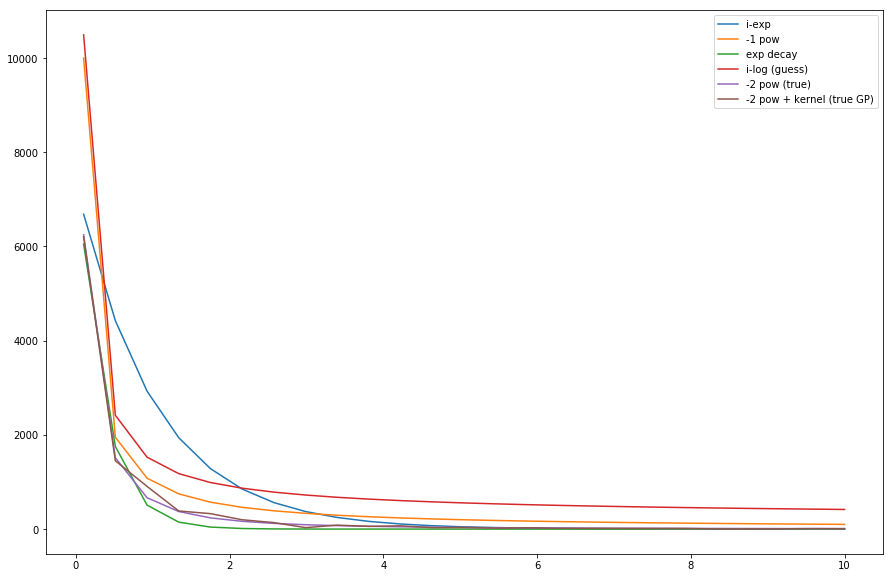

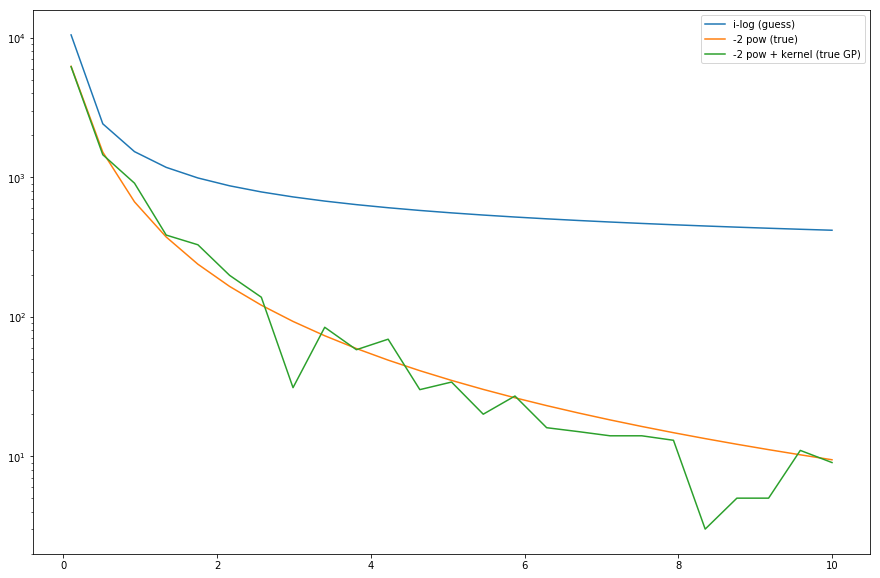

In [92]:
x = np.linspace(.1,10,25)
scale = 1
kparams = [5000., 5., 1., 2.]

y1 =  scale * f1(x)
y2 = scale * f2(x)
y3 = scale * f3(x)
yguess = scale * f4(x)
ytrue = scale * f5(x)

cov = makekernel(x, kernel1, kparams, sigma = np.sqrt(ytrue))
ytrueGP = simulate(ytrue, cov)


plt.figure(figsize=(15,10))
plt.plot(x,y1, label = "i-exp")
plt.plot(x,y2, label = "-1 pow")
plt.plot(x,y3, label = "exp decay")
plt.plot(x,yguess, label = "i-log (guess)")
plt.plot(x,ytrue, label = "-2 pow (true)")
plt.plot(x,ytrueGP, label = "-2 pow + kernel (true GP)")
plt.legend(loc='upper right')

plt.figure(figsize=(15,10))
#plt.semilogy(x,y1, label = "i-exp")
#plt.semilogy(x,y2, label = "-1 pow")
#plt.semilogy(x,y3, label = "exp decay")
plt.semilogy(x,yguess, label = "i-log (guess)")
plt.semilogy(x,ytrue, label = "-2 pow (true)")
plt.semilogy(x,ytrueGP, label = "-2 pow + kernel (true GP)")
plt.legend(loc='upper right')

plt.show()

In [93]:
from autograd.numpy.random import poisson
n = poisson(ytrue)
sigma = np.sqrt(n+1)

In [94]:
from scipy.optimize import minimize
boundarray = [(0,None) for i in n]
signal0 = np.zeros(len(n))
soln = minimize(neg_log_like_PGP_binned, n,  bounds = boundarray, args = (signal0, n, yguess, sigma), jac=nln_bin_gminerad)
print soln

      fun: 273739.4316538732
 hess_inv: <25x25 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 23.31417257,  23.39513835,  22.66786411,  21.8533139 ,
        20.71199971,  19.7866599 ,  18.27885407,  16.71254658,
        16.49454461,  11.41312314,  11.49572132,  13.43480109,
         7.04519385,   3.97200325,   5.25470725,   5.09306468,
         1.45799203,   3.77023499,  -5.45785472, -14.46421722,
        -4.30525001, -13.02628695,  -9.58681936,  -9.0464105 ,
       -36.32738123])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 8
      nit: 2
   status: 0
  success: True
        x: array([6227.67835232, 1511.57411274,  651.26354094,  366.03018657,
        219.10594243,  153.96877671,  103.389844  ,   73.86934588,
         66.04695162,   36.00917239,   33.88923995,   37.92870975,
         23.39179909,   20.6500391 ,   20.24819818,   19.40322962,
         18.3763342 ,   17.81262632,   20.17565996,   26.59705939,
         18.89013101,   24.98871697,   2

In [95]:
print cov.shape
solnGP = minimize(neg_log_like_PGP_MV, ytrueGP,  bounds = boundarray, args = (signal0 , ytrueGP, yguess, cov), jac=nln_MV_grad)
print solnGP

(25, 25)
      fun: array([[201358.17114463]])
 hess_inv: <25x25 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 24.0399958 ,  23.65930782,  23.5938003 ,  23.6005507 ,
        23.54599823,  23.52182115,  23.49098061,  22.0005527 ,
        23.4730417 ,  23.44482614,  23.71972616,  22.45326999,
        24.06151656,  23.68111843,  31.37235798,  94.73213715,
       -15.65179296,  -2.19668926,   0.61484913,   0.66501345,
        -0.93496425,  -2.51434527,  -4.63463152,  -6.74270637,
        -9.60177352])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 7
      nit: 2
   status: 0
  success: True
        x: array([6.18399514e+03, 1.43125340e+03, 8.87291823e+02, 3.65248279e+02,
       3.08267695e+02, 1.78220859e+02, 1.18158412e+02, 1.09590947e+01,
       6.39172610e+01, 3.76497750e+01, 4.83821761e+01, 8.51692645e+00,
       1.13987903e+01, 3.24830596e+00, 4.38521305e+00, 2.59864477e+00,
       4.13997545e+01, 1.92776523e+01, 1.51212718e+01, 1.34254620e+01,
  

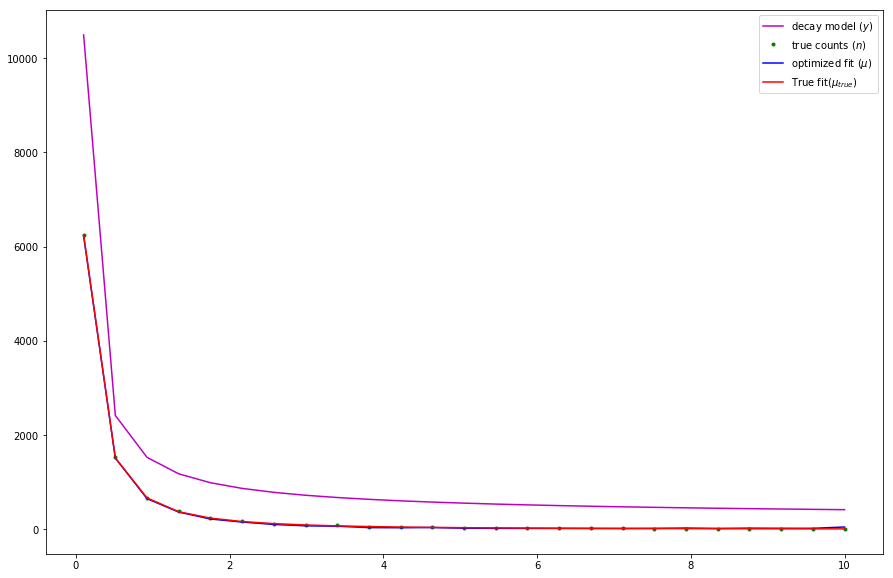

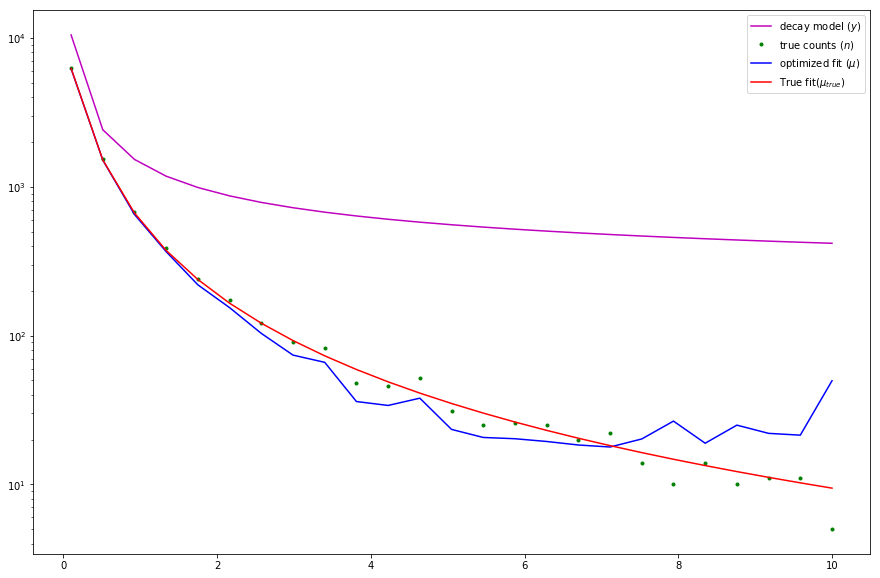

In [96]:
plt.figure(figsize=(15,10))

plt.plot(x, yguess, 'm-', label = "decay model ($y$)")
plt.plot(x, n,'g.', label = "true counts ($n$)")
plt.plot(x, soln.x,'b-', label = "optimized fit ($\mu$)")
plt.plot(x, ytrue,'r-', label = "True fit($\mu_{true}$)")
plt.legend(loc="upper right")
plt.figure(figsize=(15,10))

plt.semilogy(x, yguess, 'm-', label = "decay model ($y$)")
plt.semilogy(x, n,'g.', label = "true counts ($n$)")
plt.semilogy(x, soln.x,'b-', label = "optimized fit ($\mu$)")
plt.semilogy(x, ytrue,'r-', label = "True fit($\mu_{true}$)")

plt.legend(loc="upper right")
plt.show()

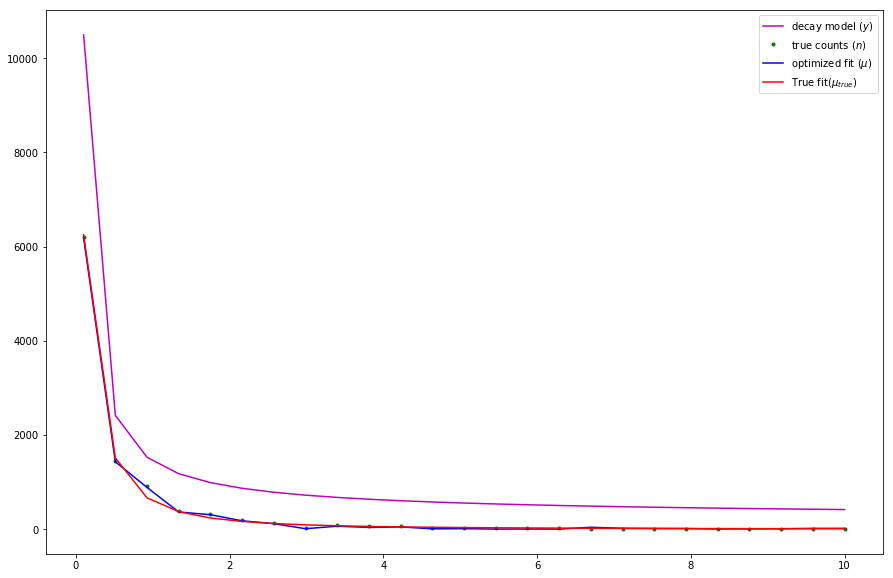

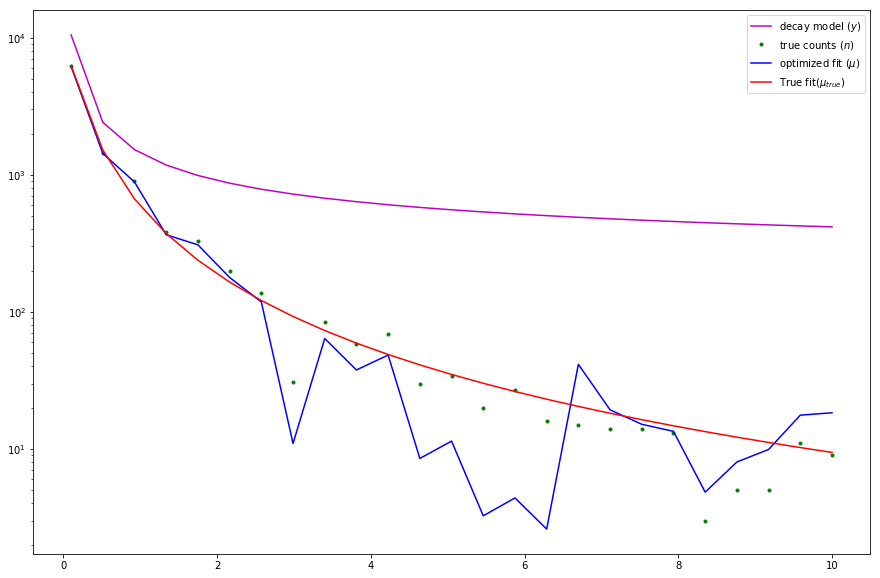

In [97]:
plt.figure(figsize=(15,10))

plt.plot(x, yguess, 'm-', label = "decay model ($y$)")
plt.plot(x, ytrueGP,'g.', label = "true counts ($n$)")
plt.plot(x, solnGP.x,'b-', label = "optimized fit ($\mu$)")
plt.plot(x, ytrue,'r-', label = "True fit($\mu_{true}$)")
plt.legend(loc="upper right")
plt.figure(figsize=(15,10))

plt.semilogy(x, yguess, 'm-', label = "decay model ($y$)")
plt.semilogy(x, ytrueGP,'g.', label = "true counts ($n$)")
plt.semilogy(x, solnGP.x,'b-', label = "optimized fit ($\mu$)")
plt.semilogy(x, ytrue,'r-', label = "True fit($\mu_{true}$)")

plt.legend(loc="upper right")
plt.show()

In [98]:
nln = neg_log_like_PGP_binned(yguess, np.zeros(len(n)), n, yguess, sigma)
nlng = nln_bin_gminerad(yguess, np.zeros(len(n)), n, yguess, sigma)

In [99]:
print cov.shape!=(100,100)

True
